## Job Salary Prediction

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import re 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Load Data

In [2]:
data = pd.read_csv('/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY669/Assignments/Individual Assignment/Train_rev1.csv')

# take 2500 random samples from the data
samples = data.sample(n=2500, random_state=123)
samples.to_csv('/Users/sheidamajidi/Desktop/Winter2024/COURSES/INSY669/Assignments/Individual Assignment/JobSalary_Prediction/samples.csv', index=False)

In [3]:
samples

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
141686,70591366,Sales Assistant,"Urgently required, immediate start avaliable. ...",Bognor Regis,Bognor Regis,part_time,NaN,Bognor Pier Leisure Ltd,Hospitality & Catering Jobs,"7.00 PER HOUR, RISING AFTER TRIAL PERIOD",13440,Jobcentre Plus
78865,69016382,Customer Service Coordinator,We are looking for a Customer service coordina...,"Skipton, North Yorkshire, West Yorkshire",West Marton,NaN,permanent,Brookstreet UK,Admin Jobs,15000/annum,15000,cv-library.co.uk
153668,70807525,Diary Secretary/Office Administrator (4 days p...,Key tasks: Provide secretarial and administra...,Bedford,Bedford,part_time,NaN,Richard Fuller MP,Admin Jobs,"16,000.00 - 18,000.00 per year Pro rata. Fixed...",17000,Jobcentre Plus
197519,71841963,Practice Manager Staffordshire,Job Description: Practice Manager Staffordshi...,"Staffordshire, Staffordshire",Staffordshire,NaN,NaN,Inspired Selections,Healthcare & Nursing Jobs,"30,000",30000,jobs.opticianonline.net
172575,71408565,Digital Strategist / Digital Senior Account Di...,This is an amazing opportunity for a digital s...,Central London,Central London,full_time,permanent,SEARCH PARTY,"PR, Advertising & Marketing Jobs",50-70k + benefits,60000,jobs.guardian.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
20580,67211823,Applications Developer ndash;Reading pound;**...,Applications Developer Reading ****k to ****k...,"Reading, England",Reading,NaN,NaN,NaN,IT Jobs,35000,35000,britishjobsonthe.net
151324,70768126,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS...,"CITY, London",The City,NaN,permanent,Lloyd Recruitment,"PR, Advertising & Marketing Jobs",65000 - 70000/annum 65000 - 70000 neg plus ben...,67500,cv-library.co.uk
126277,69995695,Graphic Design Manager Fantastic Retailer bas...,Our fantastic Multichannel Retailer are curren...,London South East,South East London,NaN,permanent,Blu Digital,"PR, Advertising & Marketing Jobs","From 35,000 to 50,000 per annum Great Brand",42500,totaljobs.com
197371,71841636,"Optometrist Chichester, West sussex",We are currently looking for an Optometrist to...,"Chichester, West Sussex, Oxfordshire, Surrey, ...",UK,NaN,NaN,Tesco Opticians,Healthcare & Nursing Jobs,"53,550 (Dependant on experience)",53550,jobs.opticianonline.net


In [4]:
# observe some of the values in the FullDescription column
samples['FullDescription'].head(10)

141686    Urgently required, immediate start avaliable. ...
78865     We are looking for a Customer service coordina...
153668    Key tasks:  Provide secretarial and administra...
197519    Job Description: Practice Manager  Staffordshi...
172575    This is an amazing opportunity for a digital s...
39952     Seeking a number of CLAS Consultants. High cal...
121894    Jones & Chapman/Swetenhams are one of the UK?s...
178146    I am looking to recruit a graduate level consu...
47350     Spencer Engineering Construction forms part of...
59346     Job Title: Claims Manager Location: Cheltenham...
Name: FullDescription, dtype: object

In [5]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 141686 to 176133
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        682 non-null    object
 6   ContractTime        1810 non-null   object
 7   Company             2141 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 253.9+ KB


In [6]:
samples.describe()

,Id,SalaryNormalized
count,2.500000e+03,2500.000000
mean,6.961107e+07,33676.852800
std,3.376747e+06,17310.414219
min,2.410433e+07,5088.000000
25%,6.869202e+07,21500.000000
50%,6.985721e+07,30000.000000
75%,7.159520e+07,41477.500000
max,7.270520e+07,144000.000000


In [7]:
# print the number of unique values in each column of 'Category','LocationNormalized','ContractType', 'ContractTime','Company'
print(samples['ContractType'].value_counts())
print(samples['ContractTime'].value_counts())

ContractType
full_time    608
part_time     74
Name: count, dtype: int64
ContractTime
permanent    1501
contract      309
Name: count, dtype: int64


<Axes: >

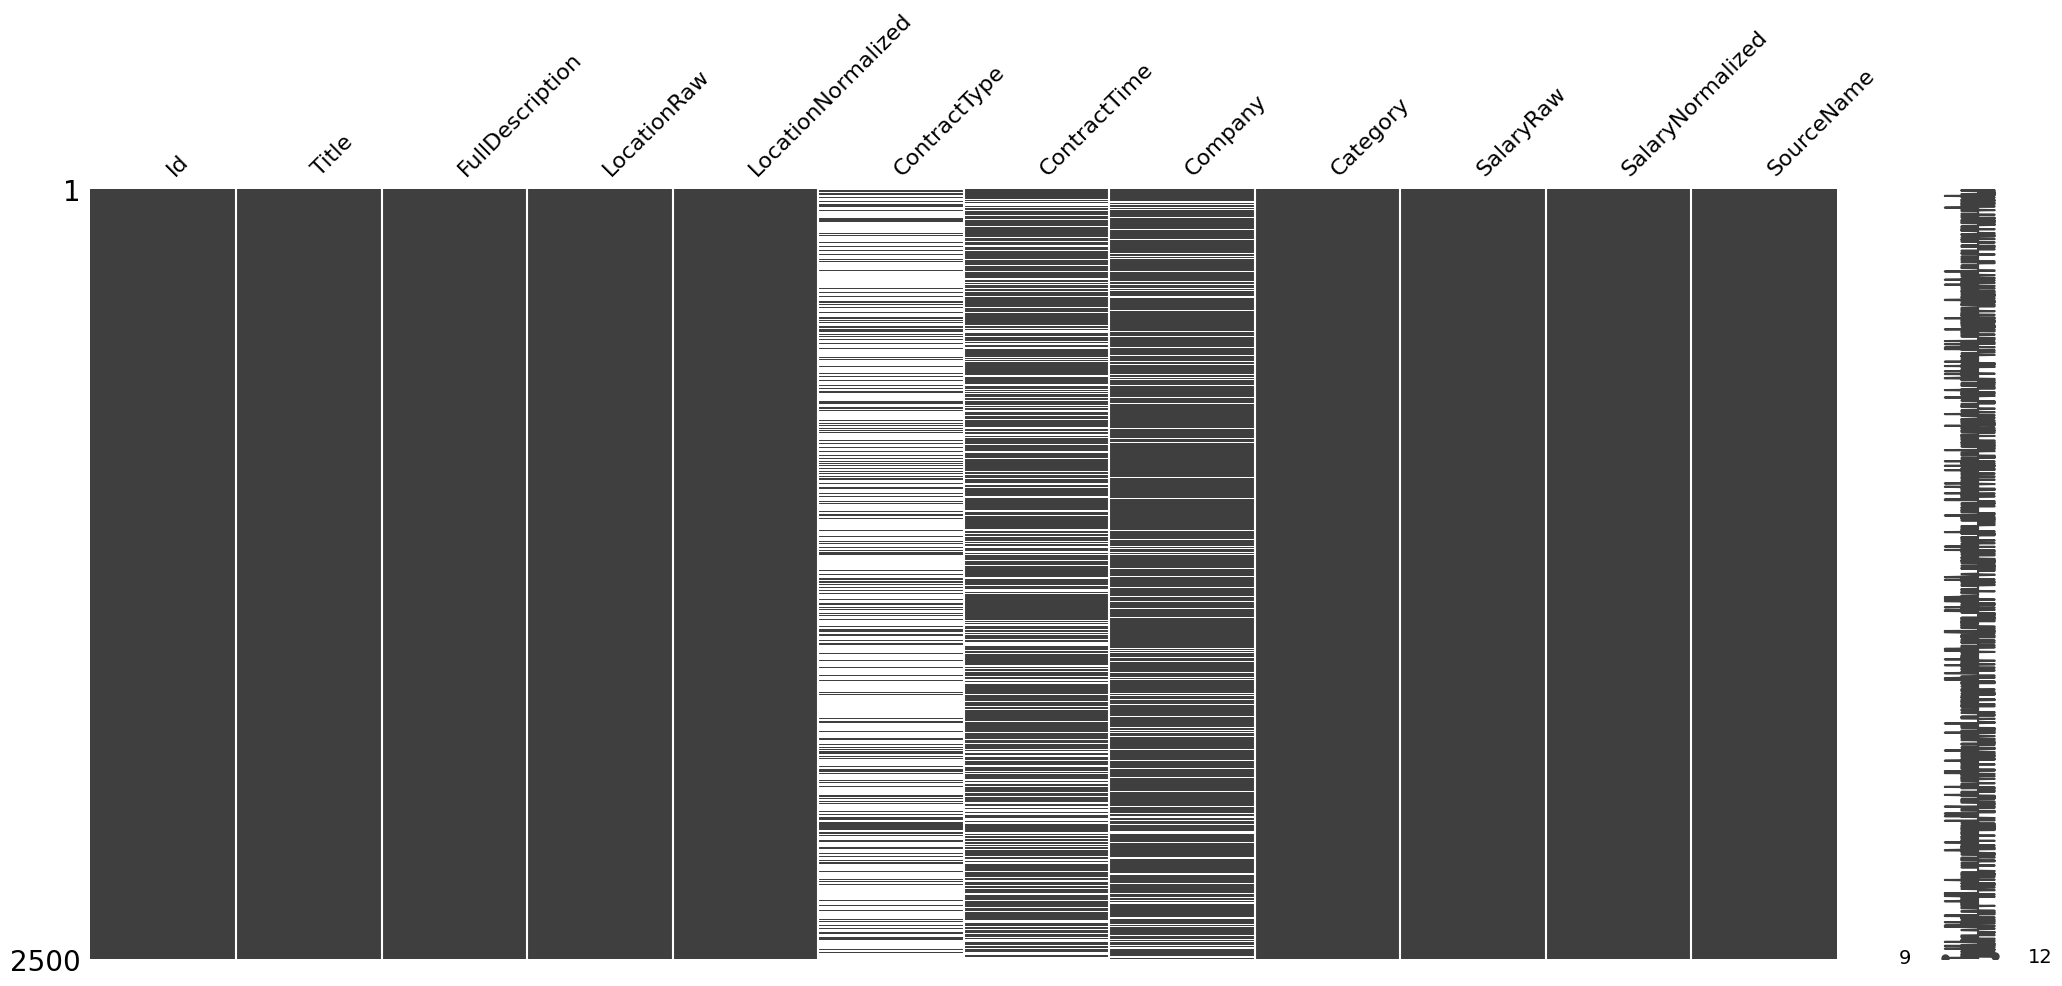

In [8]:
msno.matrix(samples)

### Preprocess Data

In [9]:
def preprocess(sentence):
    sentence = str(sentence).lower()
    sentence = sentence.replace('{html}', "")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '', cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

samples['FullDescription_Clean'] = samples['FullDescription'].apply(preprocess)


In [11]:
# categorize SalaryNormalized column into high and low
percentile_75 = samples['SalaryNormalized'].quantile(0.75)
samples['SalaryCategory'] = samples['SalaryNormalized'].apply(lambda x: 'high' if x >= percentile_75 else 'low')

In [12]:
samples

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,FullDescription_Clean,SalaryCategory
141686,70591366,Sales Assistant,"Urgently required, immediate start avaliable. ...",Bognor Regis,Bognor Regis,part_time,NaN,Bognor Pier Leisure Ltd,Hospitality & Catering Jobs,"7.00 PER HOUR, RISING AFTER TRIAL PERIOD",13440,Jobcentre Plus,urgently required immediate start avaliable mu...,low
78865,69016382,Customer Service Coordinator,We are looking for a Customer service coordina...,"Skipton, North Yorkshire, West Yorkshire",West Marton,NaN,permanent,Brookstreet UK,Admin Jobs,15000/annum,15000,cv-library.co.uk,looking customer service coordinator join crea...,low
153668,70807525,Diary Secretary/Office Administrator (4 days p...,Key tasks: Provide secretarial and administra...,Bedford,Bedford,part_time,NaN,Richard Fuller MP,Admin Jobs,"16,000.00 - 18,000.00 per year Pro rata. Fixed...",17000,Jobcentre Plus,key task provide secretarial administrative su...,low
197519,71841963,Practice Manager Staffordshire,Job Description: Practice Manager Staffordshi...,"Staffordshire, Staffordshire",Staffordshire,NaN,NaN,Inspired Selections,Healthcare & Nursing Jobs,"30,000",30000,jobs.opticianonline.net,job description practice manager staffordshire...,low
172575,71408565,Digital Strategist / Digital Senior Account Di...,This is an amazing opportunity for a digital s...,Central London,Central London,full_time,permanent,SEARCH PARTY,"PR, Advertising & Marketing Jobs",50-70k + benefits,60000,jobs.guardian.co.uk,amazing opportunity digital strategist work ac...,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,67211823,Applications Developer ndash;Reading pound;**...,Applications Developer Reading ****k to ****k...,"Reading, England",Reading,NaN,NaN,NaN,IT Jobs,35000,35000,britishjobsonthe.net,application developer reading benefit fantasti...,low
151324,70768126,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS,HEAD OF PRODUCT MARKETING TRAVEL / MOBILE APPS...,"CITY, London",The City,NaN,permanent,Lloyd Recruitment,"PR, Advertising & Marketing Jobs",65000 - 70000/annum 65000 - 70000 neg plus ben...,67500,cv-library.co.uk,head product marketing travel mobile apps loca...,high
126277,69995695,Graphic Design Manager Fantastic Retailer bas...,Our fantastic Multichannel Retailer are curren...,London South East,South East London,NaN,permanent,Blu Digital,"PR, Advertising & Marketing Jobs","From 35,000 to 50,000 per annum Great Brand",42500,totaljobs.com,fantastic multichannel retailer currently look...,high
197371,71841636,"Optometrist Chichester, West sussex",We are currently looking for an Optometrist to...,"Chichester, West Sussex, Oxfordshire, Surrey, ...",UK,NaN,NaN,Tesco Opticians,Healthcare & Nursing Jobs,"53,550 (Dependant on experience)",53550,jobs.opticianonline.net,currently looking optometrist work store chich...,high


In [13]:
# vectorizing the cleaned text
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(samples['FullDescription_Clean'])
y = samples['SalaryCategory']

### Create Test (20%) and Train (80%) Sets 

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(samples, test_size=0.2, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

train_set.to_csv("train_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

In [16]:
# print length of train and test set
print(len(train_set))
print(len(test_set))

2000
500


### Analysis

In [17]:
# training the Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [18]:
# predicting and evaluating the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.77
              precision    recall  f1-score   support

        high       0.70      0.28      0.40       137
         low       0.78      0.96      0.86       363

    accuracy                           0.77       500
   macro avg       0.74      0.62      0.63       500
weighted avg       0.76      0.77      0.73       500



### Confusion Matrix

In [19]:
# displaying the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

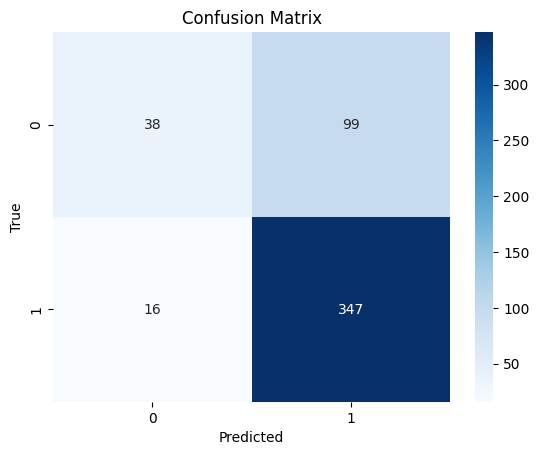

In [20]:
plot_confusion_matrix(y_test, y_pred)

### Top 10 Indicative Words for each Category

In [25]:
# finding top 10 indicative words for each category
def get_top_n_words(classifier, vectorizer, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    top_words = {}
    for i, class_label in enumerate(class_labels):
        # using `feature_log_prob_` for MultinomialNB
        top_features = np.argsort(classifier.feature_log_prob_[i])[-n:]
        top_words[class_label] = [feature_names[j] for j in top_features]
    return top_words

In [26]:
top_words = get_top_n_words(model, tfidf_vectorizer, n=10)

In [27]:
# printing top 10 words indicative of high and low salaries
print("Top 10 words indicative of high salary:")
print(top_words['high'])
print("\nTop 10 words indicative of low salary:")
print(top_words['low'])


Top 10 words indicative of high salary:
['client', 'role', 'team', 'development', 'management', 'design', 'manager', 'project', 'business', 'experience']

Top 10 words indicative of low salary:
['working', 'manager', 'customer', 'team', 'service', 'client', 'role', 'work', 'experience', 'sale']


In [28]:
# accuracy of the model
print(f'\nAccuracy: {accuracy}')


Accuracy: 0.77


## How to Increase the Accuracy

### Approach 1 - more preprocessing:
removing common but less informative words (beyond just stopwords), using n-grams to capture phrase context, and applying more advanced lemmatization techniques.

In [38]:
# improved preprocessing function
def advanced_preprocess(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-letters
    text = text.lower()  # Lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

In [39]:
samples['CleanedDescription'] = samples['FullDescription'].apply(advanced_preprocess)

In [47]:
# split the dataset into features and target variable
X = samples['CleanedDescription'] 
y = samples['SalaryCategory']

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# initialize the TfidfVectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   max_df=0.7,  # ignore terms that appear in more than 70% of the documents
                                   min_df=5,    # ignore terms that appear in less than 5 documents
                                   ngram_range=(1, 2))  # consider both unigrams and bigrams


In [49]:
# fit and transform the training data and transform the testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [54]:
# create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

# parameters for Grid Search
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 2),
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or bigrams
    'clf__alpha': (0.01, 0.1, 1),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.1, 1),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__min_df': (1, 2),
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [55]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   0.1s
[CV] END clf__alpha=0.01, tfidf__max_df=0.5, tfidf__min_df=2, tfidf__ngram

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.01, 0.1, 1),
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__min_df': (1, 2),
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [56]:
# best parameters
print("Best parameters set:")
print(grid_search.best_params_)


Best parameters set:
{'clf__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [59]:
# train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)


MultinomialNB()

In [60]:
# predict on the test set
y_pred = nb_classifier.predict(X_test_tfidf)


In [61]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.756
              precision    recall  f1-score   support

        high       0.71      0.04      0.08       125
         low       0.76      0.99      0.86       375

    accuracy                           0.76       500
   macro avg       0.74      0.52      0.47       500
weighted avg       0.75      0.76      0.66       500

